In [224]:
import pandas as pd
import glob
import numpy as np
import re
import string
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score,\
    f1_score, roc_curve, roc_auc_score, average_precision_score,classification_report,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import itertools
import gensim
from gensim.parsing.preprocessing import preprocess_string
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize, sent_tokenize

%matplotlib inline

# Table of contents

#### 1. Functions

This section contains all of the functions I use in the later sections

#### 2. Loading and preprocessing data

Here I prepare the features I'll use for modeling in the later steps

#### 3. Word importances with tf-idf

This one's just for fun.  It's neat to see the important words pop out from the tf-idf vectorizer.

#### 4. Authorship prediction via Naive Bayes

I compute a giant family of Bernoulli Naive Bayes models, one for each pair of justices with more than 20 opinions in my dataframe.

#### 5. Multi-authorship Detection via Function-Word Frequency Analysis

I compute Rosenthal's chi-squared statistic and use it to generate 95% confidence intervals.  I then plot the results, that is, which justices can be said with at least 95% confidence to have more (or less) variance than another justice.

#### 6. Document Similarity using doc2vec (gensim)

I use gensim's doc2vec to compute document similarities.

In [3]:
# Get the names of every identified author from web-scraped files
def get_judges(path):
    sub_d = glob.glob(path+"/volume*/*")
    regex = r"/volume\d+/([A-Z\d]+)"
    names = set()
    for directory in sub_d:
        name = re.search(regex, directory)
        if name:
            names.add(name[1])
    return names

In [4]:
# Get filepaths to opinions written by given author
def get_justice(author):
    cases = glob.glob(f'your/path/here/usscj/*/{author}/*')
    return cases

In [5]:
# Return dataframe containin given author's opinions, labeled with author's name and the appropriate
# volume and case for the opinion.
def author_df(author):
    paths = get_justice(author)
    df = pd.DataFrame()
    for path in paths:
        with open(path, 'rb') as f:
            text = f.read()
        text = text.decode('latin1')
        # Find volume and case numbers from filenames
        regex = r"thecase(?P<vol>\d+?)-(?P<case>[\d\-]+)"
        results = re.search(regex, path)
        row = pd.Series([author,results[1],results[2], text], index = ['Author','Volume','Case','Text'])
        df = df.append(row, ignore_index = True)
    return df

In [6]:
# Return the labels of the largest 10 elements in the series.
def top_10cols(series):
    return pd.Series(series.sort_values(ascending=False).index[:10])

In [7]:
# Return train-test splits for the given judges' opinions from the given dataframe
def compare_sets(judge_1, judge_2, df, strat = True):
    judges_df = df[(df['Author'] == judge_1) | (df['Author']==judge_2)]
    # Use text features with the author's identity removed
    X = judges_df['masked_text']
    y = (judges_df['Author']==judge_1).astype(int)
    if strat:
        return train_test_split(X,y,stratify=y)
    else:
        return train_test_split(X,y)

In [80]:
# Use a Naive Bayes estimator to classify opinions as either judge_1's or judge_2's
def compare_judges(judge_1, judge_2, df):
    X_train, X_test, y_train, y_test = compare_sets(judge_1, judge_2, df)
    # Build a pipeline for analysis.  
    # First vectorize the opinions to get text features
    # Then apply a Naive Bayes estimator
    vec_pipe = Pipeline(steps = [
        ('tf', TfidfVectorizer()),
        ('bnb', BernoulliNB())
    ])

    params = {
        # Including ngram ranges "double dips" on some features, so we'll only search over single ngram values.
        'tf__ngram_range':[(1,1),(2,2),(3,3)], 
        # Text features often run in the thousands or tens of thousands, but the model I'm comparing to
        # has a much narrower feature set of 63 1-gram features.  
        # I decided a (relatively) narrow feature set would be preferable.
        'tf__max_features':[500],
        # Tiny alpha values performed much better in Naive Bayes models.  
        # There's a lot of comparisons to do, so I picked a single small value.
        'bnb__alpha':[0.001],
        # The ideal value for maximum document frequency varied between different pairs of judges,
        # but this massively extends training time, so I picked a relatively small and equally-spaced
        # set of values.
        'tf__max_df':[0.25, 0.5, 0.75,1.0],
        # Stop words can be useful in 2-grams and 3-grams, but sometimes they're just noise.
        'tf__stop_words':[None, 'english']
    }
    gs_vec = GridSearchCV(vec_pipe,params, scoring= 'roc_auc')
    gs_vec.fit(X_train,y_train)
    probs = gs_vec.predict_proba(X_test)[:,1]
    preds = gs_vec.predict(X_test)
    return y_test, probs, preds, gs_vec.best_params_['tf__ngram_range']
    

In [ ]:
def display_results(true, probs, preds, judge_1, judge_2):
    print(f"{judge_1} vs {judge_2} SUMMARY\n")
    fpr, tpr, thresh = roc_curve(y_test,probs,drop_intermediate = True)
    plt.plot(fpr, tpr)
    plt.title(f"ROC curve | {judge_1} vs {judge_2} predictions")
    print(f"ROC-AUC:{roc_auc_score(y_test, probs)}")
    print(f"{classification_report(y_test,preds)}")
    print(f"Best parameters: {gs_vec.best_params_}")

In [122]:
def compare_all(df,min_cases = 20):
    judges = df['Author'].unique()
    to_compare = []
    for judge in judges:
        if df['Author'].value_counts()[judge] > 20:
            to_compare.append(judge)
    pairs = itertools.combinations(to_compare, 2)
    results = dict()
    for (judge_1, judge_2) in pairs:
        true, probs, preds, ngrams = compare_judges(judge_1, judge_2, full_df)
        if results.get(judge_1):
            results[judge_1][judge_2] = [true, probs, preds, ngrams]
        else:
            results[judge_1] = {judge_2: [true, probs, preds, ngrams]}
        if results.get(judge_2):
            results[judge_2][judge_1] = [true, probs, preds, ngrams]
        else:
            results[judge_2] = {judge_1:[true, probs, preds, ngrams]}
    return results

In [22]:
# Prepare text for doc2vec
# Label with opinion-unique identifier
def tag(docs):
    for i,text in enumerate(docs):
        yield TaggedDocument(gensim.utils.simple_preprocess(text), [i])

In [14]:
def best_ngrams(model):
    score_dict = dict()
    score_dict[1] = 0
    score_dict[2] = 0
    score_dict[3] = 0
    score_dict[123] = 0
    for score, param_dict in zip(model.cv_results_['mean_test_score'],model.cv_results_['params']):
        if param_dict['tf__ngram_range'] == (1,1):
            score_dict[1] = max(score_dict[1], score)
        elif param_dict['tf__ngram_range'] == (2,2):
            score_dict[2] = max(score_dict[2], score)
        elif param_dict['tf__ngram_range'] == (3,3):
            score_dict[3] = max(score_dict[3], score)
        elif param_dict['tf__ngram_range'] == (1,3):
            score_dict[123] = max(score_dict[123], score)
    return score_dict

In [72]:
# Retrieve index of given opinion
def get_index(vol, case):
    return full_df.index[(full_df['Volume'] == str(vol)) & (full_df['Case']==str(case))][0]

lawrence_v_texas = get_index(539,558)
dc_v_heller = get_index(554, 570)
citizens_united = get_index(558,310)

### Preprocessing and Loading Data

In [15]:
# make full dataframe
judges = get_judges('/your/path/here/usscj')

full_df = pd.concat([author_df(judge) for judge in judges],ignore_index=True)

# Number of opinions by author
full_df['Author'].value_counts()

SCALIA       274
KENNEDY      271
STEVENS      232
OCONNOR      215
THOMAS       211
REHNQUIST    210
GINSBURG     200
BREYER       189
SOUTER       153
WHITE        111
BLACKMUN      93
ROBERTS       91
ALITO         89
MARSHALL      69
SOTOMAYOR     65
BRENNAN       60
KAGAN         56
POWELL        19
GORSUCH        7
CHIEF          1
Name: Author, dtype: int64

In [16]:
# Ellipses ruin sentence tokenizing.  Convert them to harmless spaces.
full_df['Text'] = full_df['Text'].map(lambda x: x.replace(" . . . ", " "))
full_df['Text'] = full_df['Text'].map(lambda x: x.replace("...", " "))
full_df['Text'] = full_df['Text'].map(lambda x: x.replace("\n"," "))

In [19]:
# Remove author identifier from text.  
regex = r"(?<=court).*?(?<!M[sr])(?<!Mrs)\.(.+)"

prog = re.compile(regex, flags = re.IGNORECASE|re.DOTALL)
masked_text = full_df['Text'].map(lambda x: prog.search(x)[1])

full_df['masked_text'] = masked_text

In [23]:
# Add tagged docs to dataframe
full_df['docs'] = list(tag(full_df['masked_text']))

### Word Importances with Tf-Idf

For text data, extracting text features usually involves tokenizing a given string into smaller objects (called *tokens*), which then are used in analysis.  This can be done at the sentence-word level, changing "I threw the ball" into "I", "threw", "the", and "ball", or at the paragraph-sentence or paragraph-word level.

Our data are entire documents.  We'll be splitting them into words and then scoring these words based on their importance to that document.  This is frequently done using tf-idf vectorization.
Tf-idf refers to * **t**erm **f**requency-**i**nverse **d**ocument **f**requency*.  *Term frequency* refers to how often a term appears in a given document, whereas *document frequency* refers to how often a term appears across each document.  By multiplying the term frequency by the inverse document frequency (technically the log of this value), words are rewarded for appearing frequently in a document but punished for appearing in many other documents.

In [68]:
# Build a dataframe from the tf-idf results.
tf = TfidfVectorizer(stop_words = 'english',max_features = 2500,ngram_range=(1,1))
results = tf.fit_transform(full_df['Text'])

results_df = pd.DataFrame(results.toarray(),columns = tf.get_feature_names()).apply(top_10cols, axis=1)

In [70]:
# Civil rights case overturning law criminalizing homosexual sex acts.
results_df.iloc[lawrence_v_texas,:]

0     liberty
1     conduct
2         sex
3      sexual
4        laws
5     private
6    criminal
7     persons
8       court
9       texas
Name: 1235, dtype: object

In [71]:
# 2nd Amendment case overturning D.C. handgun ban
results_df.iloc[dc_v_heller,:]

0           right
1            bear
2       amendment
3          second
4        military
5          people
6            self
7           state
8    constitution
9          rights
Name: 1511, dtype: object

In [73]:
# 1st Amendment case finding that corporations have freedom of speech
results_df.iloc[citizens_united,:]

0          speech
1    corporations
2       political
3    expenditures
4         buckley
5       corporate
6        citizens
7             ban
8        election
9       candidate
Name: 1361, dtype: object

### Authorship prediction via Naive Bayes

The task here is to correctly predict the author of a given opinion.  For simplicity's sake, only two authors at a time will be considered.  Similar predictions were made by Rosenthal and Yoon in their 2011 article [Detecting Multiple Authorship of United States Supreme Court Legal Decisions Using Function Words](https://arxiv.org/pdf/1104.2974.pdf), but their features were 63 specific words.  I'm interested in whether ngrams can outperform their function word analysis.

I selected the Naive Bayes family of classifiers for this task to directly compare my results to Rosenthal's.  The Bernoulli Naive Bayes classifier outperformed the Multinomial and Gaussian so thoroughly that I didn't bother to include the others.

In [127]:
# Compute all the pairwise comparison models.  This takes a few hours.
nb_results = compare_all(full_df, min_cases = 20)

In [141]:
roc_scores = {}
for judge_1 in nb_results.keys():
    for judge_2 in nb_results[judge_1].keys():
        true = nb_results[judge_1][judge_2][0]
        probs = nb_results[judge_1][judge_2][1]
        if roc_scores.get(judge_1):
            roc_scores[judge_1][judge_2] = roc_auc_score(true, probs)
        else:
            roc_scores[judge_1] = {judge_2 : roc_auc_score(true,probs)}
        
roc_scores

{'ALITO': {'BLACKMUN': 0.9981060606060607,
  'BRENNAN': 1.0,
  'BREYER': 0.9990530303030303,
  'GINSBURG': 0.999108734402852,
  'KAGAN': 1.0,
  'KENNEDY': 0.9618983957219251,
  'MARSHALL': 0.9769820971867007,
  'OCONNOR': 0.9797979797979799,
  'REHNQUIST': 1.0,
  'ROBERTS': 0.7648221343873518,
  'SCALIA': 0.9696969696969697,
  'SOTOMAYOR': 0.7771739130434783,
  'SOUTER': 0.9941724941724941,
  'STEVENS': 0.9884437596302003,
  'THOMAS': 0.83704974271012,
  'WHITE': 0.9837662337662338},
 'BLACKMUN': {'ALITO': 0.9981060606060607,
  'BRENNAN': 0.8916666666666667,
  'BREYER': 1.0,
  'GINSBURG': 0.9982949701619779,
  'KAGAN': 1.0,
  'KENNEDY': 0.8452685421994884,
  'MARSHALL': 0.946078431372549,
  'OCONNOR': 0.859903381642512,
  'REHNQUIST': 0.9351927809680065,
  'ROBERTS': 0.9924385633270322,
  'SCALIA': 0.9924385633270322,
  'SOTOMAYOR': 0.9973958333333334,
  'SOUTER': 0.9843924191750278,
  'STEVENS': 0.9513633014001474,
  'THOMAS': 0.9729286300246103,
  'WHITE': 0.796583850931677},
 'BRENN

Text(0.5,1,'AUC-ROC score heatmap')

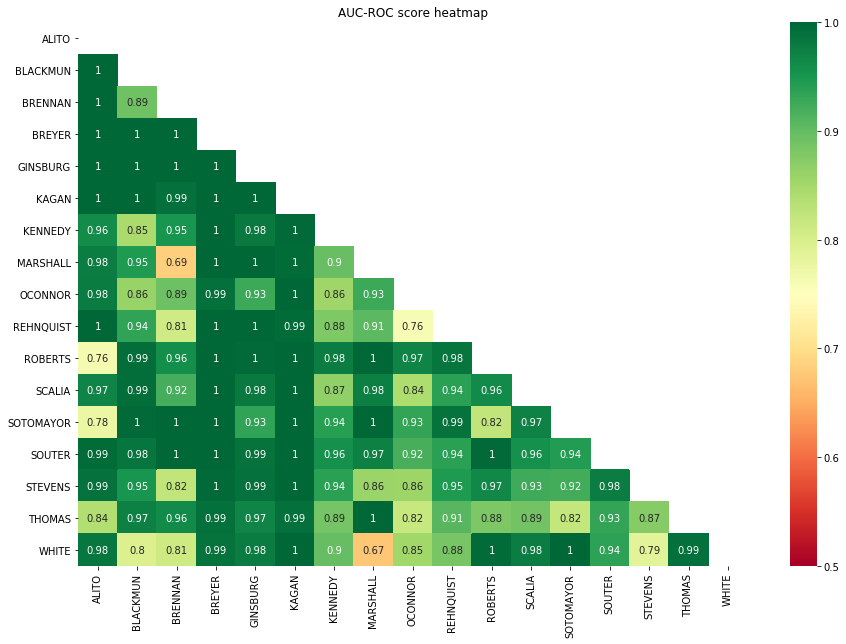

In [250]:
# Plot auc-roc scores.
roc_df = pd.DataFrame.from_dict(roc_scores)
fig, ax = plt.subplots(figsize = (15,10))
mask = np.triu(np.ones((roc_df.shape[0], roc_df.shape[1])))
sns.heatmap(roc_df,vmin = 0.5, vmax = 1.0, center = 0.75, cmap = 'RdYlGn', annot=True, mask = mask)
ax.set_title("AUC-ROC score heatmap")

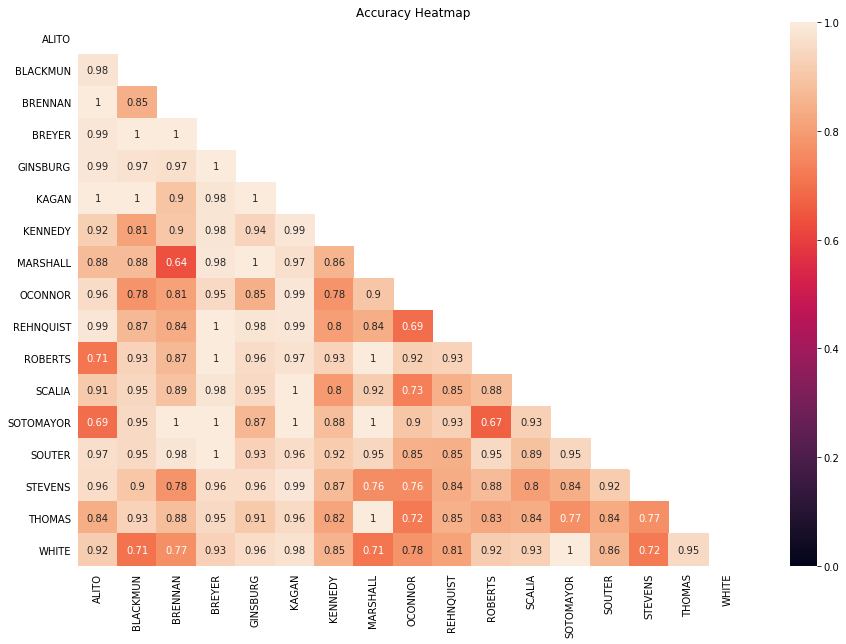

In [245]:
acc_scores = {}
for judge_1 in nb_results.keys():
    for judge_2 in nb_results[judge_1].keys():
        true = nb_results[judge_1][judge_2][0]
        preds = nb_results[judge_1][judge_2][2]
        if acc_scores.get(judge_1):
            acc_scores[judge_1][judge_2] = accuracy_score(true, preds)
        else:
            acc_scores[judge_1] = {judge_2 : accuracy_score(true,preds)}
acc_df = pd.DataFrame.from_dict(acc_scores)

# Plot accuracy heatmap
fig, ax = plt.subplots(figsize = (15, 10))
mask = np.triu(np.ones((acc_df.shape[0], acc_df.shape[1])))
sns.heatmap(acc_df,vmin = 0, vmax = 1.0, annot=True, mask = mask)
plt.tick_params(bottom=False,left=False)
ax.set_title("Accuracy Heatmap")
plt.show();

### Multi-authorship Detection via Function-Word Frequency Analysis

- The frequency of certain words is hypothesized to be constant and topic-invariant for a given author
- We can model the variance of an author's use-frequency using a chi-squared statistic
- To compare authors, we can generate a sample of variance estimates (via bootstrapping) for each author and then perform a difference-of-means test

This closely follows work done in Rosenthal Yoon's article [Detecting Multiple Authorship of United States Supreme Court Legal Decisions Using Function Words](https://arxiv.org/pdf/1104.2974.pdf)

In [168]:
# Funciton words used in Rosenthal Yoon 2011 
function_words = """a, all, also, an, and, any, are, as, at, be, been, but, by, can, do, down, even, for, from,
had, has, have, her, his, if, in, into, is, it, its, may,more, must, no, not, now, of, on,
one, only, or, our, so, some, such, than, that, the, their, then, there, things, this, to,
up, was, were, what, when, which, who, with, would""".split(",")

# Cleaning up line breaks.
function_words = [x.strip("\n ") for x in function_words]

In [169]:
# Get word counts
regex = r"(\b[a-zA-Z'\\\[\]]+\b)"
total_words = full_df['Text'].map(lambda x: len(re.findall(regex,x)))

In [170]:
# Make a dataframe with counts of function words.
# By analyzing frequencies and wordcounts, we can detect
# multiple authorship, since (by hypothesis) the 
# frequency of function words is stable for a given author.
cvec = CountVectorizer(vocabulary = function_words, token_pattern = r"(?u)\b\w+\b")
cvec.fit(full_df['masked_text'])
counts = cvec.transform(full_df['masked_text'])

counts_df = pd.DataFrame(counts.todense(), columns = cvec.get_feature_names())
counts_df['total'] = total_words

counts_df.head()

,a,all,also,an,and,any,are,as,at,be,...,up,was,were,what,when,which,who,with,would,total
0,118,3,12,28,90,5,8,12,52,31,...,0,37,6,4,21,13,16,16,30,3734
1,62,1,1,9,43,7,2,11,29,6,...,0,41,3,1,6,5,2,15,3,2780
2,235,14,11,5,51,25,7,23,41,38,...,0,14,1,1,16,42,2,22,21,4647
3,231,29,30,50,231,31,62,94,216,87,...,5,43,20,28,21,21,9,37,51,12196
4,180,16,12,64,195,38,16,54,151,62,...,9,82,44,11,12,22,4,65,44,10414


In [171]:
# Compute chisq/df statistic for a judge.
# We'll use matrix ops to speed up the computations.
def var(judge, df=None):
    if df is None:
        df = counts_df[full_df['Author']==judge]
    k = df.shape[0]
    ws = df['total']
    # This vector stores the sum of c(i,j) with respect to i.
    cij_sums = df.apply(np.sum)
    # Since j=0 is a special edge case, we'll treat it separately here.
    c0s = df['total']-df.iloc[:,:-1].apply(np.sum, axis=1)
    # Total number of words is a term that appears in many computations, so we'll store it for later use.
    total_w = np.sum(ws)
    # Build out matrix of e(i,j) terms.
    e = np.zeros((k,64))
    for i in range(1,k+1):
        for j in range(1, 64):
            # multiply the ith wordcount by the jth c(i,j) sum, then divide by total words
            e[i-1][j-1] += ((ws.iloc[i-1]*cij_sums.iloc[j-1])/total_w)
    # compute vector of e(i,0)
    e0s = ws*np.sum(c0s)/total_w
    ((c0s-e0s)**2)/e0s
    return ((((df-e)**2)/e).iloc[:,:-1].sum().sum()+np.sum(((c0s-e0s)**2)/e0s))/(63*(k-1))

In [172]:
# Check computation time
start_time = time.time()
print(var("SCALIA"))
print(time.time()-start_time)

2.9739261930384333
0.43902087211608887


In [173]:
# Compute bootstrapped variance scores.
# Pick n cases with replacement written by this author,
# compute the function word variance for these opinions,
# and repeat m times.  Return the resulting list of variance scores.
def bootstrap(judge, n=100,m=1000):
    judge_df = counts_df[full_df['Author']==judge]
    k = judge_df.shape[0]
    cases = np.random.randint(0,k,(m,n))
    var_bs = np.zeros(m)
    for i in range(m):
        var_bs[i] = var(judge, judge_df.iloc[cases[i],:])
    return var_bs

In [174]:
# Store variance scores in a dictionary.
bootstrap_variances = dict()
for judge in judges:
    bootstrap_variances[judge]=bootstrap(judge)
    print(f"Done with {judge}!")

Done with ALITO!
Done with STEVENS!
Done with SOUTER!
Done with KAGAN!
Done with ROBERTS!
Done with GORSUCH!
Done with BREYER!
Done with BLACKMUN!
Done with OCONNOR!
Done with KENNEDY!
Done with SCALIA!
Done with MARSHALL!
Done with WHITE!
Done with CHIEF!
Done with THOMAS!
Done with GINSBURG!
Done with POWELL!
Done with BRENNAN!
Done with REHNQUIST!
Done with SOTOMAYOR!


In [176]:
# Build a 95% confidence interval for differences in variance sets
def conf_int(a,b):
    differences = np.zeros(len(a)*len(b))
    for i,val_i in enumerate(a):
        for j,val_j in enumerate(b):
            differences[len(a)*i + j] = val_i-val_j
    return pd.Series(differences).quantile([0.025, 0.975])

In [192]:
# Store confidence intervals in a nested dictionary format
judge_pairs = list(itertools.combinations(judges,2))
cis = {}
for (first, second) in judge_pairs:
    if cis.get(first):
        cis[first][second] = list(conf_int(bootstrap_variances[first], bootstrap_variances[second]))
    else:
        cis[first] = {second : list(conf_int(bootstrap_variances[first], bootstrap_variances[second]))}
    if cis.get(second):
        cis[second][first] = list(conf_int(bootstrap_variances[second], bootstrap_variances[first]))
    else:
        cis[second] = {first: list(conf_int(bootstrap_variances[second], bootstrap_variances[first]))}

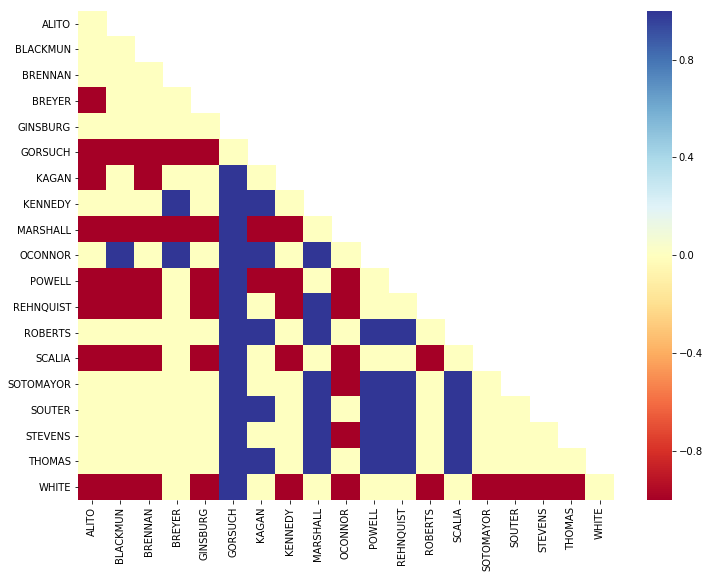

In [223]:
# Plot heatmap of which judges have more (blue) or less(red) variance in their function word frequencies.

cis_df = pd.DataFrame.from_dict(cis, orient='index').fillna(0)
cis_df = cis_df.drop('CHIEF',axis=0)
cis_df = cis_df.drop('CHIEF', axis=1)
sign_df = cis_df.applymap(lambda x: 0 if x == 0 else 0 if np.sign(x[0]*x[1]) == -1 else np.sign(x[0]))
sign_df = sign_df.reindex(sorted(sign_df.columns),axis=1)

# Plot whether the confindence intervals were above 0, contained 0, or were below 0
fig, ax = plt.subplots(figsize = (12, 9))
mask = np.ones((sign_df.shape[0], sign_df.shape[1]))
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if i >= j:
            mask[i][j] = 0
sns.heatmap(sign_df, cmap = 'RdYlBu', mask=mask)

### Document Similarity using doc2vec (gensim)

*"You shall know a word by the company it keeps."* - John Firth, linguist

Doc2vec augments word2vec with an extra input representing the document containing the context words (in the distributed-memory model) or the target word (in the distributed-bag-of-words model).

As a review, word2vec goes through each sentence with a sliding window, producing (word, context words) pairs.  Vectors are built for each word, and in the Continuous Bag-of-Words model they are used to predict a word given context words.  According to the Distributional Hypothesis, words used in similar contexts have similar meanings.

By representing each document as a vector, we can compute similarity metrics (e.g. cosine similarity) that (as we shall see) are surprisingly good at capturing semantic features between texts.

In [61]:
# 10-20 epochs are common in publishments
# vec_size in original Mikolov paper was 400, gensim intro used 100, 250 is a nice compromise
# Common practice is to reduce learning rate over each epoch of training
max_epochs = 20
vec_size = 250
alpha = 0.025

# Build a DM model
model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1,
                window=10,
               workers=24)

model.build_vocab(full_df['docs'])

In [62]:
# Train the model
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(full_df['docs'],
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

iteration 0
0.0
iteration 1
0.0
iteration 2
0.0
iteration 3
0.0
iteration 4
0.0
iteration 5
0.0
iteration 6
0.0
iteration 7
0.0
iteration 8
0.0
iteration 9
0.0
iteration 10
0.0
iteration 11
0.0
iteration 12
0.0
iteration 13
0.0
iteration 14
0.0
iteration 15
0.0
iteration 16
0.0
iteration 17
0.0
iteration 18
0.0
iteration 19
0.0


In [65]:
# Test against some famous cases
sim = model.docvecs.most_similar(lawrence_v_texas)
for (case, _) in sim:
    print(f"{full_df.loc[case,'Volume']}" + ' U.S. '+f"{full_df.loc[case,'Case']}")

576 U.S. 14-556
532 U.S. 318
505 U.S. 833
570 U.S. 12-307
530 U.S. 640
521 U.S. 702
517 U.S. 620
572 U.S. 12-682
520 U.S. 259
524 U.S. 666


The first result is *Obergefell v. Hodges*, which legalized same-sex marriage.  
The second result is *Atwater v. Lago Vista*, a 4th amendment case involving "a balancing of individual and governmental interests."  
The third result is *Planned Parenthood v. Casey*, a case that established the appropriate level of judicial scrutiny for abortion restrictions.

These all seem pretty closely related to *Lawrence v. Texas*, from a lay perspective.

In [139]:
sim = model.docvecs.most_similar(dc_v_heller)
for (case, _) in sim:
    print(f"{full_df.loc[case,'Volume']}" + ' U.S. '+f"{full_df.loc[case,'Case']}")

561 U.S. 742
527 U.S. 706
514 U.S. 779
526 U.S. 603
501 U.S. 957
523 U.S. 65
521 U.S. 507
529 U.S. 598
514 U.S. 211
519 U.S. 408


The first case is *McDonald v. City of Chicago*, a 2nd Amendment case.  
The second case is *Alden v. Maine*, a case involving the sovereign immunity of states from suits.  
The third case is *U.S. Term Limits, Inc. v. Thornton*, a case about states imposing stricter restrictions than the Constitution on representatives.  

These also seem very close to *D.C. v Heller*.

In [140]:
sim = model.docvecs.most_similar(citizens_united)
for (case, _) in sim:
    print(f"{full_df.loc[case,'Volume']}" + ' U.S. '+f"{full_df.loc[case,'Case']}")

551 U.S. 449
479 U.S. 238
539 U.S. 146
494 U.S. 652
572 U.S. 12-536
518 U.S. 604
512 U.S. 622
533 U.S. 431
564 U.S. 721
514 U.S. 334


The first case is *FEC v. Wisconsin Right to Life, Inc.*, which held that issue ads cannot be banned based on their proximity to an election.  
The second case is *FEC v. MASSACHUSETTS CITIZENS FOR LIFE, INC.*, a case involving election finance restrictions.
The third case is *Federal Election Comm'n v. Beaumont*, a case involving the extent to which corporations can spend money in political pursuits.

These also seem closely related to *Citizens United*.